In [ ]:
# imports
import sys
import numpy as np
sys.path.append('../..')
from env.gridworld import Gridworld
from examples.safe_PCE import *

In [ ]:
# Generate samples
N = 5000000
samples = truncated_gaussian(size=N)

# Plot the histogram with smoothing
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# # Create histogram data
# The `density=True` argument normalizes the histogram so the area sums to 1.
counts, bins, _ = plt.hist(samples, bins=500, density=True, edgecolor='black', alpha=0.3)

# Smooth the histogram counts
sigma = 3  # Adjust for more/less smoothing
smoothed_counts = gaussian_filter1d(counts, sigma)

# Plot smoothed curve in same color as histogram
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, smoothed_counts, 'C0-', linewidth=2, label='Noise Distribution')

plt.xlabel("noise", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Truncated Gaussian Noise Distribution (mean=0.3, std=0.03)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("truncated_gaussian_histogram.png", format='png', dpi=1200)
plt.show()

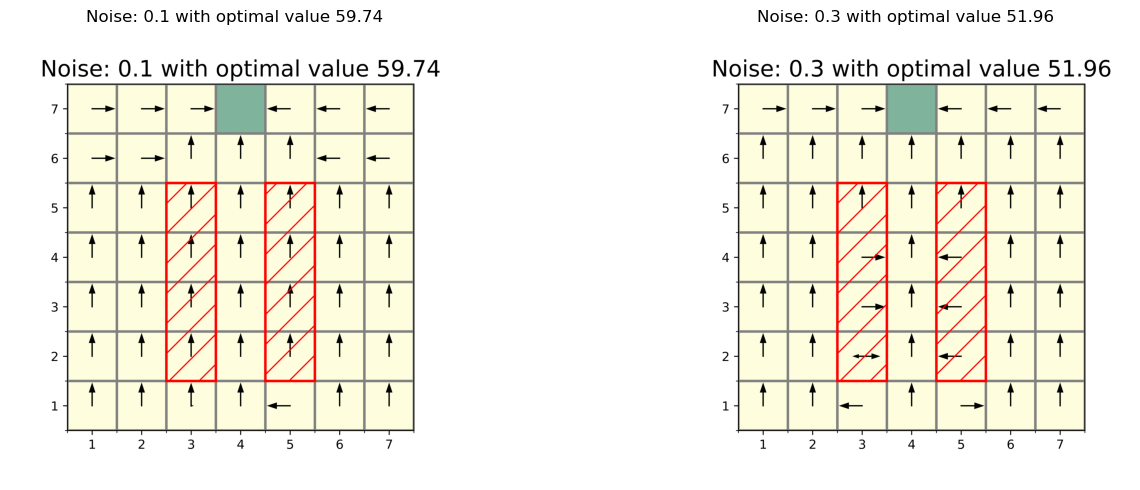

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import visualization.gridworld_vis as gv
policies = []
noises = [0.1, 0.3]

# Create a figure for plotting
fig, axes = plt.subplots(1, len(noises), figsize=(15, 5))  # 2 subplots in one row

for i, noise in enumerate(noises):
    env = make_env(noise)
    occ_measure, sol = env.lp_solve()
    policy = env.occ2policy(occ_measure)
    u = abs(sol.fun)

    # Generate and save the figure for the current environment
    constraint_patches = np.array([[[2,1],[1,4]], [[4,1],[1,4]]])
    figure = gv.plot_gridworld(env, policy, f'Noise: {noises[i]} with optimal value {round(u,2)}', env.grid_width, env.grid_height, values=env.r[:,1], constraints=constraint_patches, logging=False)

    figure_path = f"gridworld_noise{noise}.png"
    figure.set_size_inches(5, 5)  # Set figure size
    figure.savefig(figure_path, format='png', dpi=800)  # Increase dpi for higher resolution
    plt.close(figure)  # Close the figure to free memory

    # Display the figure in the subplot
    axes[i].imshow(Image.open(figure_path))
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f'Noise: {noises[i]} with optimal value {round(u,2)}')

plt.tight_layout()  # Adjust layout
plt.savefig("twoplotsgridworld.png", format='png', dpi=1200)
plt.show()  # Show all plots

In [ ]:
import sys
sys.path.append('../..')
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Load the data from the pickle file
with open("data/extracted_runs.pkl", "rb") as f:
    data = pickle.load(f)

r_run_all = data["r_run_all"]
c_run_all = data["c_run_all"]
re_avg = np.mean(r_run_all, axis=0)
re_max  = np.quantile(r_run_all, 0.9, axis=0)
re_min = np.quantile(r_run_all, 0.1, axis=0)

c_avg  = np.mean(c_run_all, axis=0)
c_max  = np.quantile(c_run_all, 0.9, axis=0)
c_min  = np.quantile(c_run_all, 0.1, axis=0)

with open("data/r_c_history_log_barrier.pkl", "rb") as f:
    data = pickle.load(f)

r_all_run_log_barrier = data["r_log"]
c_all_run_log_barrier = data["c_log"]
re_avg_log_barrier = np.mean(r_all_run_log_barrier, axis=0)
re_max_log_barrier  = np.quantile(r_all_run_log_barrier, 0.9, axis=0)
re_min_log_barrier = np.quantile(r_all_run_log_barrier, 0.1, axis=0)

c_avg_log_barrier  = np.mean(c_all_run_log_barrier, axis=0)
c_max_log_barrier  = np.quantile(c_all_run_log_barrier, 0.9, axis=0)
c_min_log_barrier  = np.quantile(c_all_run_log_barrier, 0.1, axis=0)

with open("data/r_c_history_dope_plus.pkl", "rb") as f:
    data = pickle.load(f)

r_all_run_dope_plus = data["r_dope"]
c_all_run_dope_plus = data["c_dope"]
re_avg_dope_plus = np.mean(r_all_run_dope_plus, axis=0)
re_max_dope_plus  = np.quantile(r_all_run_dope_plus, 0.9, axis=0)
re_min_dope_plus = np.quantile(r_all_run_dope_plus, 0.1, axis=0)
c_avg_dope_plus  = np.mean(c_all_run_dope_plus, axis=0)
c_max_dope_plus  = np.quantile(c_all_run_dope_plus, 0.9, axis=0)
c_min_dope_plus  = np.quantile(c_all_run_dope_plus, 0.1, axis=0)

with open("data/r_c_history_meta_safe.pkl", "rb") as f:
    data = pickle.load(f)

r_all_run_meta_safe = data["r"]
c_all_run_meta_safe = data["c"]
re_avg_meta_safe = np.mean(r_all_run_meta_safe, axis=0)
re_max_meta_safe  = np.quantile(r_all_run_meta_safe, 0.9, axis=0)
re_min_meta_safe = np.quantile(r_all_run_meta_safe, 0.1, axis=0)
c_avg_meta_safe  = np.mean(c_all_run_meta_safe, axis=0)
c_max_meta_safe  = np.quantile(c_all_run_meta_safe, 0.9, axis=0)
c_min_meta_safe  = np.quantile(c_all_run_meta_safe, 0.1, axis=0)

def thousands_formatter(x, pos):
    """Formats the tick labels to be in thousands."""
    return f'{x / 1000:.0f}'

formatter = mticker.FuncFormatter(thousands_formatter)

# Create figure with GridSpec for better control
fig = plt.figure(figsize=(15, 14))
gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.3)

# --- First subplot: Reward Regret ---
ax1 = plt.subplot(gs[0, 0])

# Plot all algorithms without individual legends
ax1.plot(range(np.size(re_avg[:])), re_avg[:], color='tab:green', linestyle='solid', linewidth=2)
ax1.fill_between(range(np.size(re_avg[:])), re_min[:], re_max[:], alpha=0.3, facecolor='tab:green')

ax1.plot(range(np.size(re_avg_log_barrier[:])), re_avg_log_barrier[:], color='tab:purple', linestyle='solid', linewidth=2)
ax1.fill_between(range(np.size(re_avg_log_barrier[:])), re_min_log_barrier[:], re_max_log_barrier[:], alpha=0.3, facecolor='tab:purple')

ax1.plot(range(np.size(re_avg_dope_plus[:])), re_avg_dope_plus[:], color='tab:orange', linestyle='solid', linewidth=2)
ax1.fill_between(range(np.size(re_avg_dope_plus[:])), re_min_dope_plus[:], re_max_dope_plus[:], alpha=0.3, facecolor='tab:orange')

ax1.plot(range(np.size(re_avg_meta_safe[:])), re_avg_meta_safe[:], color='tab:pink', linestyle='solid', linewidth=2)
ax1.fill_between(range(np.size(re_avg_meta_safe[:])), re_min_meta_safe[:], re_max_meta_safe[:], alpha=0.3, facecolor='tab:pink')

ax1.tick_params(labelsize=20)
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlabel("Iteration number k ($\\times 10^3$)", color='black', fontsize=22)
ax1.set_ylabel("Reward regret ($\\times 10^3$)", color='black', fontsize=22)
ax1.set_title('Reward regret across different environments', fontsize=24)
ax1.grid(alpha=0.3)

# --- Second subplot: Constraint Values ---
ax2 = plt.subplot(gs[1, 0])

ax2.plot(range(np.size(c_avg[:])), c_avg[:], color='tab:green', linestyle='solid', linewidth=2)
ax2.fill_between(range(np.size(c_avg[:])), c_min[:], c_max[:], alpha=0.3, facecolor='tab:green')

ax2.plot(range(np.size(c_avg_log_barrier[:])), c_avg_log_barrier[:], color='tab:purple', linestyle='solid', linewidth=2)
ax2.fill_between(range(np.size(c_avg_log_barrier[:])), c_min_log_barrier[:], c_max_log_barrier[:], alpha=0.3, facecolor='tab:purple')

ax2.plot(range(np.size(c_avg_dope_plus[:])), c_avg_dope_plus[:], color='tab:orange', linestyle='solid', linewidth=2)
ax2.fill_between(range(np.size(c_avg_dope_plus[:])), c_min_dope_plus[:], c_max_dope_plus[:], alpha=0.3, facecolor='tab:orange')

ax2.plot(range(np.size(c_avg_meta_safe[:])), c_avg_meta_safe[:], color='tab:pink', linestyle='solid', linewidth=2)
ax2.fill_between(range(np.size(c_avg_meta_safe[:])), c_min_meta_safe[:], c_max_meta_safe[:], alpha=0.3, facecolor='tab:pink')

# Add threshold line (will show in subplot legend only)
ax2.axhline(y=1.5, color='tab:red', linewidth=2, label='Threshold = 1.5')

ax2.tick_params(labelsize=20)
ax2.xaxis.set_major_formatter(formatter)
ax2.set_xlabel("Iteration number k ($\\times 10^3$)", color='black', fontsize=22)
ax2.set_ylabel("Constraint value", color='black', fontsize=22)
ax2.set_title('Constraint values across different environments', fontsize=24)
ax2.grid(alpha=0.3)

# Add legend to the second subplot only
ax2.legend(fontsize=20, loc='upper left')

# --- Create a single shared legend at the top (without threshold) ---
legend_elements = [
    Patch(facecolor='tab:green', alpha=0.6, label='Our algorithm'),
    Patch(facecolor='tab:pink', alpha=0.6, label='Safe Meta-RL'),
    Patch(facecolor='tab:orange', alpha=0.6, label='DOPE+'),
    Patch(facecolor='tab:purple', alpha=0.6, label='LB-SGD')
]
# Add legend above the plots
fig.legend(handles=legend_elements, loc='upper center', ncol=4, 
           fontsize=20, frameon=True, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for legend at top
plt.savefig("plots/compare_safe_LB_SGD_dope_plus_vertical.png", format='png', dpi=800, bbox_inches='tight')
plt.show()